# Data Management

## Create a project folder

Here is a recommended folder structure for your fMRI project. 

```bash
# An example folder structure for an fMRI project
#
# └── new_study_template               # the project name
#     └── code
#         └── analysis                 # analysis scripts folder
#         └── preprocessing            # preprocessing scripts (heudiconv, mriqc, fmriprep)
#         └── task                     # experimental task code
#     └── data
#         └── behavioral               # other behavioural data
#         └── bids                     # this is where raw BIDS data will be saved by HeuDiConv
#         └── dicom                    # raw dicoms copied from the scanner
#         └── work                     # work (intermediate) files generated by fMRIprep and MRIQC
#     └── doc                          # project notes and manuscript
#     └── results                      #  
```

You can create it manually or you can use a simple `bash` script. Let's call it `create_study_template.sh`
```bash
#!/bin/bash
new_study=$1 # this will be your project name that you pass to this script
mkdir -p "$new_study"/{code/{analysis,preprocessing,task},data/{bids,dicom,work},doc,results}
```

To run this script, write the following in the terminal: `./create_study_template.sh FaceRecognition`

## Version control

To initiate your analysis version control, you'd type the following in the terminal:
```bash
cd FaceRecognition
git init
```

You don't need to track everything in your project. Mainly, you'd like to track your analysis scripts, and perhaps your documents. Basically, everything that is 'text based'. To exclude certain directories from being tracked, you can create a `.gitignore` file. 

Here I create a `.gitignore` file and specify that I don't want my 'data' and 'results' directories being tracked. 
```bash
touch .gitignore
echo data >>.gitignore
echo results >>.gitignore
```
For basic `git` commands, see, for example, this [Git Cheat Sheet](https://about.gitlab.com/images/press/git-cheat-sheet.pdf)

## Retrieving the DICOM files

`DICOM` files are the raw imaging files that come from the MRI scanner. Usually they are stored on some MRI data server. At the CBU, each imaging project has a unique code. Knowing my project's code, I can locate the raw `DICOM` files on our server.


In [ ]:
ls -d /mridata/cbu/*_MR09029

In may cases, you wouldn't even need to copy these data from the imaging server to your directory. You could only store the converted `NIfTI` files. But sometimes it is just more convenient to copy them over. **But don't foget to delete them from your folder once you have converted the data!** You can always retrieve the raw files from their original location.

For our example study, only 16 of these folders (participants) have the complete data that we need. I have copied these to my `/data/dicom` folder. I used the following `bash` script for that:

```bash
#!/bin/bash
set -eu

sourcepath="/mridata/cbu/"
destpath="/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/dicom/"

projectCode="MR09029"
CBUid=("CBU090942" "CBU090938" "CBU090964" "CBU090928" "CBU090931" "CBU090935" "CBU090970" "CBU090956" "CBU090958" "CBU090968" "CBU090957" "CBU090966" "CBU090951" "CBU090945" "CBU090962" "CBU090967")
nr=0
for id in "${CBUid[@]}"; do
    nr=$((nr + 1))
    # change sub id to be 01 02 ...
    newid=$(printf "%02d" "$nr")

    source="$sourcepath""$id"_"$projectCode"
    destination="$destpath""$newid"

    srun -N1 -n1 -c1 cp -R "$source" "$destination" &
    echo "$source"  copied
    echo 'Remove 2 Dummy scans from each functional run ( 210-2=208 )!'
done
```

In the script, I changed the subject ID's to be 01, 02 etc. It is not necessary to do so, but it just looks 'nicer', I think. And in this studie's version on OpenNeuro, subjects are numbered like that. Here I matched my subject ID's to the OpenNeuro version. 

In [ ]:
!tree /imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/dicom

## Dummy scans

When we start acquiring fMRI data, scanner needs some time to reach a steady state. Therefore a common practice is to dicard the first couple of volumes - **the dummy scans**. Often it is done at the scanner level and we never see these scans. But sometimes we need to discard them ourselves from the DICOM files that we get from the scanner. In this example case, we need to dicard the first two volumes from each functional run (2 dummy scans). 

You can exclude them at later stages of your analysis, but I find it less troublesome to exclude them already from the DICOM files. 

When excluding dummies, make sure you accordingly adjust our stimulus onset times!

## Brain Imaging Data Structure (BIDS)

To proceed with analysis, we need to convert the `DICOMs` to `NIfTI` format and then organise all these files in a 'nice' way.

[Brain Imaging Data Structure (**BIDS**)](https://bids-specification.readthedocs.io/en/stable/) is a a standard for organizing and describing neuroimaging (and behavioural) datasets. See [BIDS paper](https://doi.org/10.1038/sdata.2016.44) and http://bids.neuroimaging.io website for more information.

How to get your DICOMs into NIfTI and into BIDS?

Several tools exist. I will here demonstrate [HeudiConv](https://heudiconv.readthedocs.io/en/latest/index.html). 

`heudiconv` is a flexible `DICOM` converter for organizing brain imaging data into structured directory layouts.
* It allows flexible directory layouts and naming schemes through customizable heuristics implementations
* It only converts the necessary DICOMs, not everything in a directory
* You can keep links to DICOM files in the participant layout
* Using `dcm2niix` under the hood, it’s fast
* It provides assistance in converting to `BIDS`.


### HeudiConv

```
pip install heudiconv==0.11.3
conda install dcm2nii 
```
(What's the difference between `pip` and `conda`, you wonder? [See here](https://pythonspeed.com/articles/conda-vs-pip/))

Or use Docker or Singularity

`heidiconv` involves 3 main steps:
1. Discover what type of DICOM files you have
2. Create a 'heuristics' for how to translate DICOMs into your desired layout (i.e., BIDS)
3. Converts DICOMs to NIfTI and uses the heuristics file to accordingly organise the .nii.gz and their corresponding .json files. 


#### DICOM discover

`step01_heudiconv_dicom_discover.sh`
```bash
#!/bin/bash
d_path="/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/dicom/"
o_path="/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/"
sid="01"
# -d, --dicom_dir_template
# -o, --outdir
# -f, --heuristic
# -s, --subjects
# -c, --converter
# -b, --bids
heudiconv \
    -d $d_path/{subject}/*/*/*.dcm \
    -o $o_path/data/work/dicom_discovery/ \
    -f convertall \
    -s $sid \
    -c none \
    -b --overwrite
```
`./step01_heudiconv_dicom_discover.sh`

Btw, you can also call `shell scripts` from `Python`. See an example below. 

In [ ]:
import os
import subprocess
pdir = "/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition"

#subprocess.call(os.path.join(pdir, "code/preprocessing/step01_heudiconv_dicom_discover.sh"))


Now navigate to the created output directory. In my case `/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/work/dicom_discovery/`
And there go to `.heudiconv/[sub-id]/info` and open `dicominfo.tsv` file.

Or open it here, in the notebook.

In [ ]:
import pandas as pd

infopath = os.path.join(pdir, "data/work/dicom_discovery/.heudiconv/01/info", "dicominfo.tsv")
pd.read_csv(infopath, sep = '\t')

#### Heuristics file

`heudiconv_heuristic.py`

```python
import os

def create_key(template, outtype=('nii.gz',), annotation_classes=None):
    if template is None or not template:
        raise ValueError('Template must be a valid format string')
    return template, outtype, annotation_classes

def infotodict(seqinfo):
    # BIDS keys
    anat = create_key('sub-{subject}/anat/sub-{subject}_acq-mprage_T1w')
    fmap_mag = create_key('sub-{subject}/fmap/sub-{subject}_magnitude')
    fmap_phase = create_key('sub-{subject}/fmap/sub-{subject}_phasediff')
    func_task = create_key('sub-{subject}/func/sub-{subject}_task-facerecognition_run-0{item:01d}_bold')

    info = {anat: [], fmap_mag: [], fmap_phase: [],
            func_task: []}

    for idx, s in enumerate(seqinfo):
        # anat T1w
        if (s.dim1 == 256) and ("MPRAGE" in s.protocol_name):
            info[anat].append(s.series_id)
        # Field map Magnitude
        if (s.dim3 == 66) and ('FieldMapping' in s.protocol_name):
            info[fmap_mag].append(s.series_id)
        # Field map PhaseDiff
        if (s.dim3 == 33) and ('FieldMapping' in s.protocol_name):
            info[fmap_phase].append(s.series_id)        
        # Functional Bold
        if (s.dim1 == 64) and (s.dim4 > 100):
            info[func_task].append(s.series_id)
                
    return info
```

#### Convert DICOM to BIDS

Similar as we did in DICOM discovery. But now we specify the heuristics file and the converter (*dcm2niix*), so that the files are actually converted. 

An example script for converting a single subject:

`example_dicom2bids_single-subject.sh`

```bash
#!/bin/bash
d_path="/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/dicom/"
o_path="/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/"
sid="01"
# -d, --dicom_dir_template
# -o, --outdir
# -f, --heuristic
# -s, --subjects
# -c, --converter
# -b, --bids
heudiconv \
    -d $d_path/{subject}/*/*/*.dcm \
    -o $o_path/data/bids/ \
    -f $o_path/code/preprocessing/heudiconv_heurisctic.py \
    -s $sid \
    -c dcm2niix \
    -b --overwrite
```
`./example_dicom2bids_single-subject.sh`

If we have many participants, then creating subject by subject sequentially is not very practical. Instead, you could create a `batch job` and convert all subjects at the same time. 

`step02_heudiconv_batch`
```bash
#!/bin/bash
# ======================================================================
# Dace Apšvalka (MRC CBU 2022)
# ======================================================================
set -eu

# Project path needs to be specified when submitting the function
PROJECT_PATH=${1}
# Where the dicoms are located
DICOM_PATH="${PROJECT_PATH}"/data/dicom/
# Where to output jobs
JOB_DIR="$PROJECT_PATH"/data/work/bids/jobs
mkdir -p "$JOB_DIR"
cd "$JOB_DIR"
# Get the list of subject for this project
# each subfolder in the dicom path
SUBJECT_LIST=()
for d in "$DICOM_PATH"*; do
    sub_id=$(basename "$d")
    SUBJECT_LIST+=("$sub_id")
done
# Submit to the dicom2bids script as a job array on SLURM
sbatch --array=0-$((${#SUBJECT_LIST[@]} - 1)) "$PROJECT_PATH"/code/preprocessing/step02_heudiconv_run.sh "${PROJECT_PATH}" "${DICOM_PATH}" "${SUBJECT_LIST[@]}"
```

The `batch job` calls and executes this script:

`02_heudiconv_run.sh`
```bash
#!/bin/bash
# ======================================================================
# Dace Apšvalka (MRC CBU 2022)
# ======================================================================
set -eu

# Project path needs to be specified when submitting the function
PROJECT_PATH=${1}
# Where the dicoms are located
DICOM_PATH=${2}
# where to output the data
OUTDIR="$PROJECT_PATH"/data/bids
# All list items of the 3rd variable from batch-dicom2bids
SUBJECT_LIST=("${@:3}")
# Index each subject per job array
subject=${SUBJECT_LIST[${SLURM_ARRAY_TASK_ID}]}

# Processing start time
start=$(date +%s)
# Write out the starting details
date
echo Submitted subject: "${subject}"
echo DICOM path: "$DICOM_PATH""${subject}"/

# Do the conversion using heudiconv
heudiconv \
    -d "${DICOM_PATH}"{subject}/*/*/*.dcm \
    -o "${OUTDIR}" \
    -f "${PROJECT_PATH}"/code/preprocessing/heudiconv_heurisctic.py \
    -s "${subject}" \
    -c dcm2niix \
    -b --overwrite

# Procesing end time
end=$(date +%s)
# Write out the elapssed processing time
echo Time elapsed: "$(TZ=UTC0 printf '%(%H:%M:%S)T\n' $((end - start)))"
```
To run the `batch script`, you'd write in the terminal:

`./step02_heudiconv_batch.sh /imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/`

It tkes about 5 min to convert all my 16 subjects.

------------
<div style='background-color: yellow'>
Inspect the output.   
</div>

------------------

### 'To Do' - additional information to check and add

#### Dataset description

`dataset_description.json`

We can get the information here: https://openneuro.org/datasets/ds000117/versions/1.0.5/file-display/dataset_description.json

#### Participants

`participants.json`

Check and edit the information as needed.

#### Task information

`task-facerecognition_bold.json`

Could add full task name and a Cognitive Atlas ID if known. 

#### Events
You need to fill in your experiment trial onsets and durations. 

Here I retrieve the event timing information from the OpenNeuro version of this dataset. In this version, the dummy scans had been removed and timings adjusted accordingly. As I have also removed the dummy scans, I can use these timings without any further adjustement (well, some adjustments will be needed!). 

Here, to demonstrate that you can also edit and run `Matlab` ecripts from `VSCode`, is a `Matlab` script that I wrote to get the event information in my BIDS events files. 

You'd run this script from a terminal: `matlab2019a -batch "step04_BIDS_copy_events"`

`MATLAB script`
```C
% Copy event information from Wakeman's ds000117 to my ExampleStudy
clearvars
source = '/imaging/correia/dace/training/summer-school/Wakeman-ds/ds000117';
destination = '/imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/bids';
nsub = 16;
nrun = 9;

for i = 1:nsub
    sub = ['sub-' num2str(i,'%02.f')];
    sourceDir = fullfile(source, sub, 'ses-mri', 'func');
    sourceList = dir(fullfile(sourceDir, '*.tsv'));
    
    destDir = fullfile(destination, sub, 'func');
    destList = dir(fullfile(destDir, '*.tsv'));
    
    for f = 1:nrun
        f1 = fullfile(sourceList(f).folder, sourceList(f).name);
        f2 = fullfile(destList(f).folder, destList(f).name);
        copyfile(f1, f2, 'f');
    end
end
```
Later (in my analysis) I discovered, that I needed to make some amends to the copied events files. According to `BIDS` specification for [Task Events](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html), a correct column name is 'trial_type', not 'stim_type'. Also, an emtpy trial name for the 'rest' period was problematic. So, I fixed these issues with the script below. 

```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmath import nan
import os
import glob
import sys
import pandas as pd

path_root = sys.argv[1]
path_events = os.path.join(path_root, '*', 'func', '*_events.tsv')

# get all fieldmap files in the data-set:
files_events = glob.glob(path_events)
# loop over all event files:
for file_path in files_events:
    # read in the event file
    events = pd.read_table(file_path)
    # rename the column
    events.rename(columns={"stim_type": "trial_type"}, inplace=True)
    # fill empty trial type as REST
    events["trial_type"].replace(nan, 'REST', inplace=True)
    # save the updated file
    events.to_csv(file_path, sep="\t", index=False)
    print(file_path, " updated")
```

#### README

*"TODO: Provide description for the dataset -- basic details about the study, possibly pointing to pre-registration (if public or embargoed)"*

See an example for the OpenNeuro version of this dataset https://openneuro.org/datasets/ds000117/versions/1.0.5/file-display/README

### Validate BIDS structure

Does our newly created directory and file structure complies with the `BIDS` standart? We can check it with an [online BIDS validator](https://bids-standard.github.io/bids-validator/).

We get some warnings about events custom columns that have no description. We can include events.json file that contains this information. For guidance see the BIDS specification https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html

Suspiciously long event: `sub-10_task-facerecognition_run-09_events.tsv`. Can add this information in the README file: *Owing to scanner error, Subject 10 only has 170 volumes in last run (Run 9) (hence the BIDS warning of some onsets in events.tsv file being later than the data)* 


### Field Maps 'Intended For' field needs to be added

For later pre-processing steps to work smoothly, we need to add `IntendedFor` field to fieldmap JASONs

`step03_BIDS_add-IntendedFor.py` to link fieldmaps to functional scans.

```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# SCRIPT INFORMATION:
# Add IntendedFor to Fieldmap JSON files
# Adapted from LENNART WITTKUHN https://github.com/lnnrtwttkhn/highspeed-bids
# ======================================================================
# IMPORT RELEVANT PACKAGES
# ======================================================================
import os
import glob
import json
import stat
import sys
# ======================================================================
# DEFINE PATHS
# ======================================================================
# to run type python3 bids-fieldmaps.py $PATH_ROOT
path_root = sys.argv[1]
path_fmap = os.path.join(path_root, '*', 'fmap', '*.json')
path_func = os.path.join(path_root, '*', 'func', '*.nii.gz')
# ======================================================================
# UPDATE FIELDMAP JSON FILES
# ======================================================================
# get all fieldmap files in the data-set:
files_fmap = glob.glob(path_fmap)
# loop over all field-map files:
for file_path in files_fmap:
    # open the .json file of the fieldmap acquisition:
    with open(file_path, 'r') as in_file:
        json_info = json.load(in_file)
    in_file.close()
    # get the path to the session folder of a specific participant:
    file_base = os.path.dirname(os.path.dirname(file_path))
    # get the path to all functional acquisitions in that session:
    files_func = glob.glob(os.path.join(file_base, 'func', '*bold.nii.gz'))
    #session = os.path.basename(file_base)
    #up_dirs = os.path.join(session, 'func')
    up_dirs = 'func'
    intended_for = [os.path.join(up_dirs, os.path.basename(file)) for file in files_func]
    json_info["IntendedFor"] = sorted(intended_for)
    # change file permissions to read:
    permissions = os.stat(file_path).st_mode
    os.chmod(path=file_path, mode=permissions | stat.S_IWUSR)
    # save updated fieldmap json-file:
    with open(file_path, 'w') as out_file:
        json.dump(json_info, out_file, indent=2, sort_keys=True)
    out_file.close()
    # change file permissions back to read-only:
    os.chmod(path=file_path, mode=permissions)
```

`python3 step03_BIDS_add-IntendedFor.py /imaging/correia/dace/training/summer-school/Example_v02/FaceRecognition/data/bids`

### Additional help on BIDS

[BIDS for MRI: Structure and Conversion by Taylor Salo](https://osf.io/fbj5u) (video, 13:39)

[Stanford BIDS Tutorial Series: HeuDiConv Walkthrough](https://reproducibility.stanford.edu/bids-tutorial-series-part-2a/)

[Neurostars forum, BIDS tag](https://neurostars.org/tags/bids)


## PyBIDS

`PyBids` is a Python module to interface with datasets conforming BIDS. See the [documentation](https://bids-standard.github.io/pybids/) and [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7409983/) for more info. `PyBids` can be installed with `pip install pybids` command.

**Here we will explore some of the functionality of pybids.layout.** The material is adapted from https://github.com/bids-standard/pybids/tree/master/examples

In [6]:
import os
from bids.layout import BIDSLayout
from bids.tests import get_test_data_path

ds_path = '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids'

# Initialize the layout
layout = BIDSLayout(ds_path)

# Print some basic information about the layout
layout

BIDS Layout: ..._v03/FaceRecognition/data/bids | Subjects: 16 | Sessions: 0 | Runs: 144

### Querying the BIDSLayout
The main method for querying `BIDSLayout` is `.get()`.

If we call `.get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

In [7]:
all_files = layout.get()
print("There are {} files in the layout.".format(len(all_files)))
print("\nThe first 5 files are:")
all_files[:5]

There are 583 files in the layout.

The first 5 files are:


[<BIDSFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/CHANGES'>,
 <BIDSJSONFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/dataset_description.json'>,
 <BIDSJSONFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/participants.json'>,
 <BIDSDataFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/participants.tsv'>,
 <BIDSFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/README'>]

The returned object is a **Python list**. Each element in the list is a `BIDSFile` object. 

We can also get just filenames.

In [8]:
layout.get(return_type='filename')[:5]

['/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/CHANGES',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/dataset_description.json',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/participants.json',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/participants.tsv',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/README']

We can also get such information as
* all `subject` IDs
* all `task` names
* dataset `description`
* the BOLD repetition time TR
* how many `runs` there are

In [9]:
layout.get_subjects()

['16',
 '14',
 '05',
 '15',
 '07',
 '09',
 '11',
 '03',
 '10',
 '01',
 '12',
 '13',
 '04',
 '08',
 '02',
 '06']

In [10]:
layout.get_tasks()

['facerecognition']

In [11]:
layout.get_dataset_description()

{'Acknowledgements': 'TODO: whom you want to acknowledge',
 'Authors': ['TODO:', 'First1 Last1', 'First2 Last2', '...'],
 'BIDSVersion': '1.4.1',
 'DatasetDOI': 'TODO: eventually a DOI for the dataset',
 'Funding': ['TODO', 'GRANT #1', 'GRANT #2'],
 'HowToAcknowledge': 'TODO: describe how to acknowledge -- either cite a corresponding paper, or just in acknowledgement section',
 'License': 'TODO: choose a license, e.g. PDDL (http://opendatacommons.org/licenses/pddl/)',
 'Name': 'TODO: name of the dataset',
 'ReferencesAndLinks': ['TODO', 'List of papers or websites']}

In [12]:
layout.get_tr()

2.0

Regarding runs, it might be that there are varied number of runs accross participants. So, let's get runs for each participant. 

In [13]:
for sID in layout.get_subjects(): 
    print(layout.get_runs(subject = sID))

[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]
[01, 02, 03, 04, 05, 06, 07, 08, 09]


### Filtering files by entities
We can pass any BIDS-defined entities (keywords) to `.get()` method. For example, here's how we would retrieve all BOLD runs with `.nii.gz` extensions for subject `04`.

In [15]:
# Retrieve filenames of all BOLD runs for subject 01
layout.get(subject='04', run='04', extension='nii.gz', suffix='bold', return_type='filename')

['/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-04_bold.nii.gz']

All of the entities are found in the names of BIDS files. For example `sub-01_task-facerecognition_run-01_bold.nii.gz` has entities: **subject** **task** **run** **suffix** **extension**.

You can get the list of all availabe entities by `layout.get_entities()`.

Here are a few of the most common entities:

* `suffix`: The part of a BIDS filename just before the extension (e.g., 'bold', 'events', 'T1w', etc.).
* `subject`: The subject label
* `session`: The session label
* `run`: The run index
* `task`: The task name

In [16]:
layout.get_entities()

{'subject': <Entity subject (pattern=[/\\]+sub-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'session': <Entity session (pattern=[_/\\]+ses-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'sample': <Entity sample (pattern=[_/\\]+sample-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'task': <Entity task (pattern=[_/\\]+task-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'acquisition': <Entity acquisition (pattern=[_/\\]+acq-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'ceagent': <Entity ceagent (pattern=[_/\\]+ce-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'staining': <Entity staining (pattern=[_/\\]+stain-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'tracer': <Entity tracer (pattern=[_/\\]+trc-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'reconstruction': <Entity reconstruction (pattern=[_/\\]+rec-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'direction': <Entity direction (pattern=[_/\\]+dir-([a-zA-Z0-9]+), dtype=<class 'str'>)>,
 'run': <Entity run (pattern=[_/\\]+run-(\d+), dtype=<class 'bids.layout.utils.PaddedInt'>)>,
 'proc': <Enti

### Filtering by metadata
Sometimes we want to search for files based not just on their names, but also based on metadata defined in JSON files. We can pass any key that occurs in any JSON file in our project as an argument to `.get()`. We can combine these with any number of core BIDS entities (like `subject`, `run`, etc.).

For example, we want to retrieve `SpacingBetweenSlices` for all our subjects. And let's create a nice data frame of this information.

In [17]:
import pandas as pd
d = []
for subject in layout.get_subjects():
    d.append(
        {
            'subject': subject,
            'spacing': layout.get_SpacingBetweenSlices(subject=subject, suffix='bold')
        }
    )
df = pd.DataFrame(d)
df = df.sort_values(by=['subject'])

print(df.to_string(index=False))

subject spacing
     01  [3.75]
     02   [3.9]
     03   [3.9]
     04   [3.9]
     05  [3.75]
     06  [4.05]
     07  [3.75]
     08  [3.75]
     09  [3.75]
     10   [3.9]
     11  [3.75]
     12  [3.75]
     13   [3.9]
     14  [3.75]
     15   [3.9]
     16  [4.05]


### Other `return_type` values
We can also ask `get()` to return unique values (or IDs) of particular entities. For example, we want to know which subjects have at least one `T1w` file. We can request that information by setting `return_type='id'`. When using this option, we also need to specify a target entity (or metadata keyword) called `target`. This combination tells the `BIDSLayout` to return the unique values for the specified `target` entity. 

For example, in the next example, we ask for all of the unique subject IDs that have at least one file with a `phasediff` suffix. 

In [18]:
# Ask get() to return the ids of subjects that have phasediff (fieldmap_ files
layout.get(return_type='id', target='subject', suffix='phasediff')

['16',
 '14',
 '05',
 '15',
 '07',
 '09',
 '11',
 '03',
 '10',
 '01',
 '12',
 '13',
 '04',
 '08',
 '02',
 '06']

If our `target` is a BIDS entity that corresponds to a particular directory in the BIDS specification (e.g., `subject` or `session`) we can also use `return_type='dir'` to get all matching subdirectories. 

In [19]:
layout.get(return_type='dir', target='subject')

['/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-02',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-03',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-05',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-06',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-07',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-08',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-09',
 '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-10',
 '/imaging/correia/dace/training/summer-school/Example_v03/F

### The `BIDSFile`
When you call `.get()` on a `BIDSLayout`, the default returned values are objects of class `BIDSFile`. A `BIDSFile` is a lightweight container for individual files in a BIDS dataset. It provides easy access to a variety of useful attributes and methods. Let's take a closer look. First, let's pick a random file from our existing `layout`.

In [20]:
# Pick the 7th file in the dataset
bf = layout.get()[7]
# Print it
bf

<BIDSImageFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01/anat/sub-01_acq-mprage_T1w.nii.gz'>

Here are some of the attributes and methods available to us in a `BIDSFile` (note that some of these are only available for certain subclasses of `BIDSFile`; e.g., you can't call `get_image()` on a `BIDSFile` that doesn't correspond to an image file!):
* `.path`: The full path of the associated file
* `.filename`: The associated file's filename (without directory)
* `.dirname`: The directory containing the file
* `.get_entities()`: Returns information about entities associated with this `BIDSFile` (optionally including metadata)
* `.get_image()`: Returns the file contents as a nibabel image (only works for image files)
* `.get_df()`: Get file contents as a pandas DataFrame (only works for TSV files)
* `.get_metadata()`: Returns a dictionary of all metadata found in associated JSON files
* `.get_associations()`: Returns a list of all files associated with this one in some way

Let's see some of these in action.

In [21]:
# Print all the entities associated with this file, and their values
bf.get_entities()

{'acquisition': 'mprage',
 'datatype': 'anat',
 'extension': '.nii.gz',
 'subject': '01',
 'suffix': 'T1w'}

In [22]:
# Print all the metadata associated with this file
bf.get_metadata()

{'AcquisitionMatrixPE': 246,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '16:43:32.335000',
 'BaseResolution': 256,
 'CoilCombinationMethod': 'Adaptive Combine',
 'CoilString': 'T:HEA;HEP',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20220720',
 'DeviceSerialNumber': '35119',
 'DwellTime': 8.5e-06,
 'EchoTime': 0.00298,
 'FlipAngle': 9,
 'HeudiconvVersion': '0.11.3',
 'ImageComments': 'V',
 'ImageOrientationPatientDICOM': [0, 1, 0, 0, 0, -1],
 'ImageOrientationText': 'Sag',
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM'],
 'ImagingFrequency': 123.252,
 'InPlanePhaseEncodingDirectionDICOM': 'ROW',
 'InstitutionAddress': 'Chaucer Road  15,Cambridge,UK,GB,CB2 2EF',
 'InstitutionName': 'MRC-CBU',
 'InversionTime': 0.9,
 'MRAcquisitionType': '3D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'TrioTim',
 'MatrixCoilMode': 'GRAPPA',
 'Modality': 'MR',
 'NonlinearGradientCorrection': True,
 'ParallelReductionFactorInPl

In [23]:
# We can the union of both of the above in one shot like this
bf.get_entities(metadata='all')

{'AcquisitionMatrixPE': 246,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '16:43:32.335000',
 'BaseResolution': 256,
 'CoilCombinationMethod': 'Adaptive Combine',
 'CoilString': 'T:HEA;HEP',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20220720',
 'DeviceSerialNumber': '35119',
 'DwellTime': 8.5e-06,
 'EchoTime': 0.00298,
 'FlipAngle': 9,
 'HeudiconvVersion': '0.11.3',
 'ImageComments': 'V',
 'ImageOrientationPatientDICOM': [0, 1, 0, 0, 0, -1],
 'ImageOrientationText': 'Sag',
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM'],
 'ImagingFrequency': 123.252,
 'InPlanePhaseEncodingDirectionDICOM': 'ROW',
 'InstitutionAddress': 'Chaucer Road  15,Cambridge,UK,GB,CB2 2EF',
 'InstitutionName': 'MRC-CBU',
 'InversionTime': 0.9,
 'MRAcquisitionType': '3D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'TrioTim',
 'MatrixCoilMode': 'GRAPPA',
 'Modality': 'MR',
 'NonlinearGradientCorrection': True,
 'ParallelReductionFactorInPl

Here are all the files associated with our target file in some way.

In [24]:
bf.get_associations()

[<BIDSJSONFile filename='/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01/anat/sub-01_acq-mprage_T1w.json'>]

`.get_image()`: Returns the file contents as a `nibabel` image (only works for image files). We can then display the image, for example, using `OrthoSlicer3D` which requires `matplotlib`.   

**Note:** When using `orthoview()` in notebook, don't forget to close figures afterward again or use %matplotlib inline again, otherwise, you cannot plot any other figures.

<IPython.core.display.Javascript object>


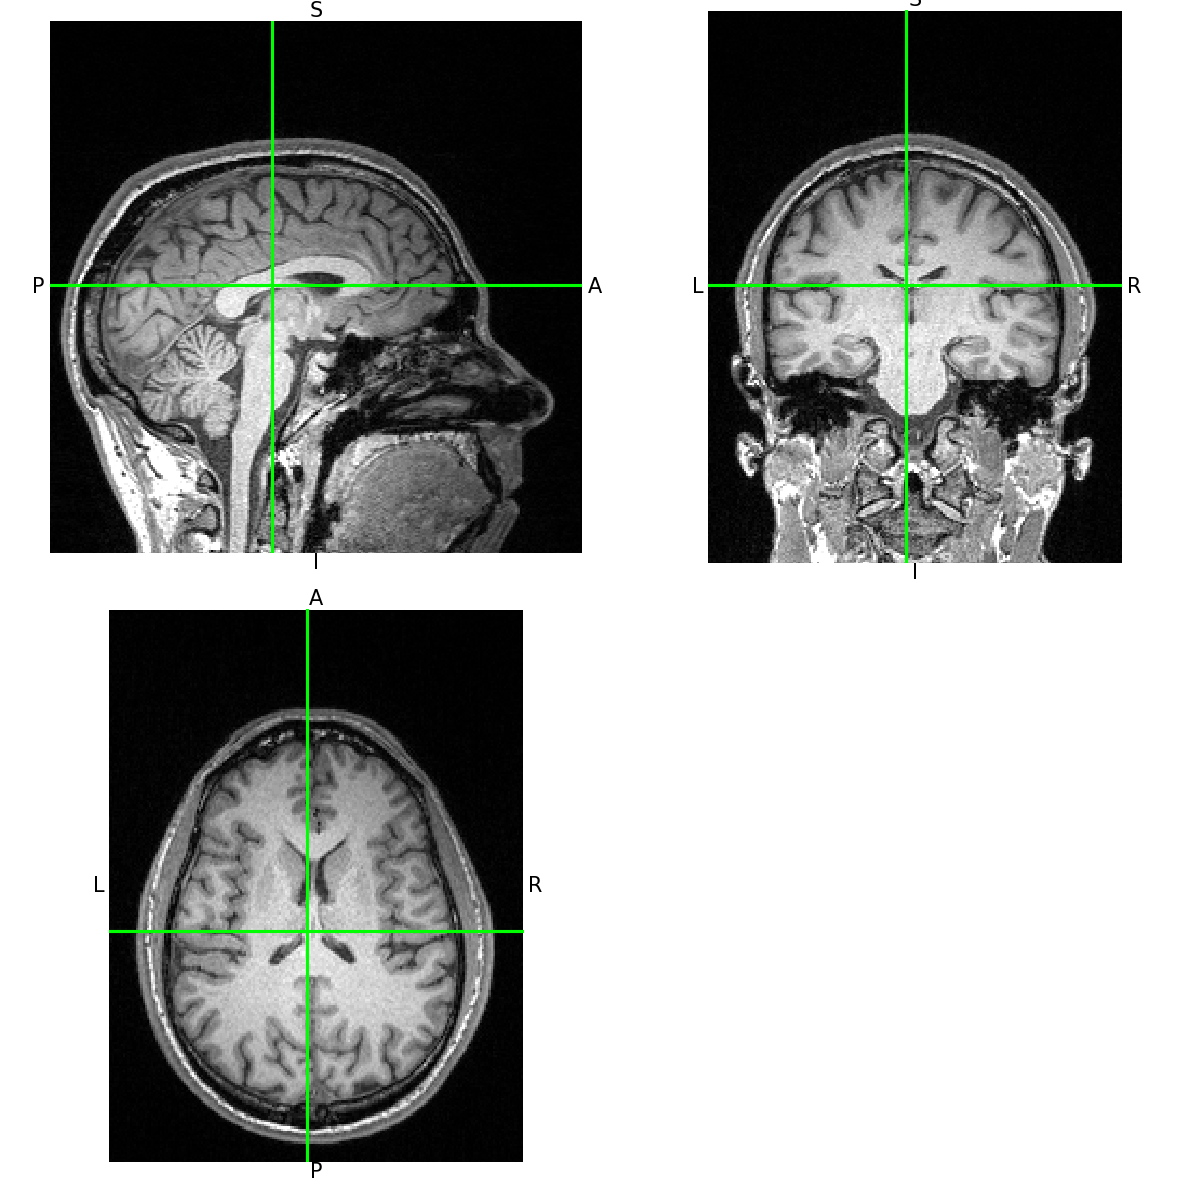

<OrthoSlicer3D: /imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01/anat/sub-01_acq-mprage_T1w.nii.gz (192, 256, 256)>

In [25]:
import matplotlib.pyplot as plt
%matplotlib notebook

bf.get_image().orthoview()

### `.tsv` files

In cases where a file has a `.tsv.gz` or `.tsv` extension, it will automatically be created as a `BIDSDataFile`, and we can easily grab the contents as a `DataFrame`.

Let's look at the first `events` file from our layout.

In [26]:
# Get the first events file
evfile = layout.get(suffix='events')[0]

# Get contents as a DataFrame and show the first few rows
df = evfile.get_df()
df.head()

,onset,duration,circle_duration,trial_type,trigger,button_pushed,response_time,stim_file
0,0.000,0.908,0.534,FAMOUS,5,4.0,2.158,func/f013.bmp
1,3.273,0.962,0.586,FAMOUS,6,4.0,1.233,func/f013.bmp
2,6.647,0.825,0.546,UNFAMILIAR,13,4.0,1.183,func/u014.bmp
3,9.838,0.968,0.597,UNFAMILIAR,14,4.0,0.930,func/u014.bmp
4,12.978,0.904,0.415,UNFAMILIAR,13,7.0,1.068,func/u016.bmp


Let's look at the `participants` information. 

In [27]:
participants = layout.get(suffix='participants', extension='tsv')[0]
participants.get_df()

,participant_id,age,sex,group
0,sub-04,26,F,control
1,sub-12,24,F,control
2,sub-15,30,M,control
3,sub-11,24,F,control
4,sub-14,24,F,control
5,sub-09,29,M,control
6,sub-07,31,F,control
7,sub-06,26,M,control
8,sub-01,31,M,control
9,sub-03,30,M,control


### Other utilities

### Filename parsing
Let's say you have a filename, and you want to manually extract BIDS entities from it. The parse_file_entities method provides the facility:

In [28]:
layout.parse_file_entities('some_path_to_bids_file/sub-04_task-facerecognition_run-01_bold.nii.gz')

{'subject': '04',
 'task': 'facerecognition',
 'run': 01,
 'suffix': 'bold',
 'extension': '.nii.gz'}

You can do the same for `BIDSFile` object that we defined earlier. 

In [29]:
layout.parse_file_entities(bf.path)

{'subject': '01',
 'acquisition': 'mprage',
 'suffix': 'T1w',
 'datatype': 'anat',
 'extension': '.nii.gz'}

### Path construction
You may want to create valid BIDS filenames for files that are new or hypothetical that would sit within your BIDS project. This is useful when you know what entity values you need to write out to, but don’t want to deal with looking up the precise BIDS file-naming syntax. In the example below, imagine we’ve created a new file containing stimulus presentation information, and we want to save it to a `.tsv.gz` file, per the BIDS naming conventions. All we need to do is define a dictionary with the name components, and build_path takes care of the rest (including injecting sub-directories!):

In [35]:
entities = {
    'subject': '01',
    'run': '02',
    'task': 'facerecognition',
    'suffix': 'bold'
}

layout.build_path(entities)

'/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01/func/sub-01_task-face-recognition_run-02_bold.nii.gz'

Keep in mind that `_` and `-` have special meaning in BIDS specification. E.g., you can't name your task `face-recognition`, that would not be 'spec-compliant' and would end in an error! However, if you add `validate=False`, you can get away with it (i'e', `layout.build_path(entities, validate=False)`). 

You can also use `build_path` in more sophisticated ways by defining your own set of matching templates that cover cases not supported by BIDS out of the box. For example, suppose you want to create a template for naming a new `stat` file. You could do something like:

In [36]:
# Define the pattern to build out of the components passed in the dictionary
pattern = "sub-{subject}[_ses-{session}]_task-{task}[_run-{run}]_{suffix}.nii.gz"

entities = {
    'subject': '01',
    'run': '02',
    'task': 'facerecognition',
    'suffix': 'stat'
}

# Notice we pass the new pattern as the second argument
layout.build_path(entities, pattern, validate=False)

'/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-01_task-facerecognition_run-02_stat.nii.gz'

### Exporting a `BIDSLayout` to a pandas `Dataframe`
If you want a summary of all the files in your `BIDSLayout`, but don't want to have to iterate `BIDSFile` objects and extract their entities, you can get a nice bird's-eye view of your dataset using the `to_df()` method.

In [37]:
# Convert the layout to a pandas dataframe
df = layout.to_df()
df.head()

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/layout/layout.py:525: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.pivot('path', 'entity', 'value')


entity,path,acquisition,datatype,extension,fmap,run,scans,subject,suffix,task
0,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,.json,NaN,NaN,NaN,NaN,description,NaN
1,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,.json,NaN,NaN,NaN,NaN,participants,NaN
2,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,.tsv,NaN,NaN,NaN,NaN,participants,NaN
3,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,.json,NaN,NaN,NaN,NaN,scans,NaN
4,/imaging/correia/dace/training/summer-school/E...,mprage,anat,.json,NaN,NaN,NaN,01,T1w,NaN


We can also include metadata in the result if we like (which may blow up our `DataFrame` if we have a large dataset). Note that in this case, most of our cells will have missing values.

In [38]:
df = layout.to_df(metadata=True)
df.head()

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/layout/layout.py:525: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = data.pivot('path', 'entity', 'value')


entity,path,AcquisitionMatrixPE,AcquisitionNumber,AcquisitionTime,BandwidthPerPixelPhaseEncode,BaseResolution,CogAtlasID,CoilCombinationMethod,CoilString,ConversionSoftware,...,group,operator,participant_id,randstr,run,scans,sex,subject,suffix,task
0,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,description,NaN
1,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,participants,NaN
2,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,{'Description': '(TODO: adjust - by default ev...,NaN,{'Description': 'Participant identifier'},NaN,NaN,NaN,"{'Description': 'self-rated by participant, M ...",NaN,participants,NaN
3,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scans,NaN
4,/imaging/correia/dace/training/summer-school/E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,T1w,NaN


### Report generation
`PyBIDS` also allows you to automatically create data acquisition reports based on the available `image` and `meta-data` information. This enables a new level of standardisation and transparency. FAIR-ness, meta-analyses, etc. 

In [39]:
# import the BIDSReport function from the reports submodule
from bids.reports import BIDSReport

Now we only need to apply the `BIDSReport` function to our `layout` and generate our report. 

In your example dataset the report might run into error as the dataset is incomplete. The code below deals with that case. But a successfull report would look something like this:

>In session None, MR data were acquired using a 3-Tesla Siemens TrioTim MRI scanner.
	One run of T1-weighted SP\MP\OSP GR\IR (GR\IR) single-echo structural MRI data were collected (256 slices; repetition time, TR=2250ms; echo time, TE=2.98ms; flip angle, FA=9<deg>; field of view, FOV=192x256mm; matrix size=192x256; voxel size=1x1x1mm).
	A spoiled gradient recalled (GR) field map (phase encoding: anterior to posterior; 33 slices in interleaved ascending order; repetition time, TR=400ms; echo time 1 / 2, TE1/2=5.197.65ms; flip angle, FA=60<deg>; field of view, FOV=192x192mm; matrix size=64x64; voxel size=3x3x3.75mm) was acquired for the first, second, third, fourth, fifth, sixth, seventh, eighth, and ninth runs of the facerecognition BOLD scan.
	Nine runs of facerecognition segmented k-space echo planar (EP) single-echo fMRI data were collected (33 slices in interleaved ascending order; repetition time, TR=2000ms; echo time, TE=30ms; flip angle, FA=78<deg>; field of view, FOV=192x192mm; matrix size=64x64; voxel size=3x3x3.75mm). Run duration was 6:56 minutes, during which 208 volumes were acquired.

>Dicoms were converted to NIfTI-1 format using dcm2niix (v1.0.20220720). This section was (in part) generated automatically using pybids (0.15.3).

In [40]:
# Initialize a report for the dataset
report = BIDSReport(layout)

# Method generate returns a Counter of unique descriptions across subjects
try:
    descriptions = report.generate()
    pub_description = descriptions.most_common()[0][0]
    print(pub_description)
except IndexError:
    print('Sorry, it seems that the dataset is not complete and report cannot be generated.')

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/reports/parsing.py:387: UserWarning: sub-16_magnitude1.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/reports/parsing.py:387: UserWarning: sub-16_magnitude2.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/layout/models.py:219: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['run'] instead of .run.
  warnings.warn("Accessing entities as attributes is deprecated as "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/reports/parsing.py:387: UserWarning: sub-14_magnitude1.nii.gz not yet supported.
  warnings.warn(group[0].filename + " not yet supported.")
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/bids/reports/parsing.py:387: User

Number of patterns detected: 6
Remember to double-check everything and to replace <deg> with a degree symbol.
In session None, MR data were acquired using a 3-Tesla Siemens TrioTim MRI scanner.
	One run of T1-weighted SP\MP\OSP GR\IR (GR\IR) single-echo structural MRI data were collected (256 slices; repetition time, TR=2250ms; echo time, TE=2.98ms; flip angle, FA=9<deg>; field of view, FOV=192x256mm; matrix size=192x256; voxel size=1x1x1mm).
	A spoiled gradient recalled (GR) field map (phase encoding: anterior to posterior; 33 slices in interleaved ascending order; repetition time, TR=400ms; echo time 1 / 2, TE1/2=5.197.65ms; flip angle, FA=60<deg>; field of view, FOV=192x192mm; matrix size=64x64; voxel size=3x3x3.75mm) was acquired for the first, second, third, fourth, fifth, sixth, seventh, eighth, and ninth runs of the facerecognition BOLD scan.
	Nine runs of facerecognition segmented k-space echo planar (EP) single-echo fMRI data were collected (33 slices in interleaved ascending 